# Calculations for Air-Water CO2 Gas Exchange

<br>

##### Dataset
- https://arcticdata.io/catalog/view/doi%3A10.18739%2FA2V97ZR7H 

<br>

In [1]:
# File and Data Manipulation
import os                       # interacting with the operating system
import glob                     # retrieving files/pathnames matching a specified pattern
from collections import Counter # counting hashable objects
import shutil                   # high-level file operations
import pickle                   # serializing and de-serializing Python object structures

# Data Analysis
import numpy as np              # numerical operations
import pandas as pd             # data manipulation and analysis

# Geospatial Data Handling
import geopandas as gpd         # working with geospatial data

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt       # creating static, interactive, and animated visualizations
plt.style.use("default")              # Set the default style matplotlib plots
import matplotlib.colors as mcolors   # colors for legend
import matplotlib.patches as mpatches # drawing patches (shapes) for legend
from matplotlib.ticker import MaxNLocator     # control the maximum number of ticks on plots
from matplotlib.ticker import MultipleLocator # control tick intervals on plots
import matplotlib.ticker as mticker           # advanced tick formatting and placement
from matplotlib.dates import HourLocator, DateFormatter
import matplotlib.dates as mdates
# Dates
import datetime
import matplotlib.dates as mdate
#from matplotlib.dates import HourLocator, DateFormatters
years  =  mdates.YearLocator()
months =  mdates.MonthLocator()
days   =  mdates.DayLocator()
hours  =  mdates.HourLocator()
month_name = DateFormatter("%b")
day_name = DateFormatter('%d')

# Suppress Warnings
import warnings                 # handling warnings
warnings.filterwarnings("ignore") # Suppress all warnings (use with caution

#### Functions

In [2]:
###################################################################################################
# Find Max/Min For a column and Show one other Columns
def find_min_max_1(dataframe, column_name):
    min_val, min_date = dataframe[column_name].min(), dataframe[column_name].idxmin()
    max_val, max_date = dataframe[column_name].max(), dataframe[column_name].idxmax()
    print(f"Min {column_name} @ {min_val} on {min_date}")
    print(f"Max {column_name} @ {max_val} on {max_date}")
    
###################################################################################################
# Find Max/Min For a column and Show two other Columns
def find_min_max_2(dataframe, primary_col, additional_col):
    """
    Find and print the minimum and maximum values of a specified column in a DataFrame, 
    along with the corresponding values of another column at those points.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame to analyze.
    primary_col (str): The name of the primary column to find min and max values.
    additional_col (str): The name of the additional column for retrieving related values.

    Returns:
    None: This function prints the results and does not return a value.
    """
    # Find min and max of the primary column
    min_val, min_date = dataframe[primary_col].min(), dataframe[primary_col].idxmin()
    max_val, max_date  = dataframe[primary_col].max(), dataframe[primary_col].idxmax()
    # Retrieve values from the additional column at min and max dates
    additional_val_at_min = dataframe.loc[min_date, additional_col]
    additional_val_at_max = dataframe.loc[max_date, additional_col]
    print(f"Min {primary_col} @ {min_val} on {min_date} @ {additional_col}: {additional_val_at_min}")
    print(f"Max {primary_col} @ {max_val} on {max_date} @ {additional_col}: {additional_val_at_max}")

###################################################################################################
# Histograms
def plot_columns_single_row(df, columns, bins=51, alpha=0.7, sharey=True):
    """
    Plots histograms for specified columns in a DataFrame, all in a single row.

    :df: DataFrame containing the data.
    :columns: List of column names (str) to plot.
    :bins: Number of bins for the histogram.
    :alpha: Alpha blending value for the histogram.
    
    Returns:
    None: This function creates a plot but does not return any value.
    """
    num_cols = len(columns)
    fig, ax = plt.subplots(1, num_cols, figsize=(9, 3), sharey=sharey)

    ax[0].set_ylabel('Frequency', labelpad=20, fontsize=12)
    ax[0].yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)
    
    for i, col in enumerate(columns):
        data = df[col]
        mean = data.mean()
        std = data.std()
        
        # Histogram plot
        counts, bins_array, patches = ax[i].hist(data, bins=bins, edgecolor='black', color='blue', alpha=alpha)

        # Find the bin with the maximum frequency
        max_count = counts.max()
        max_bin_index = counts.argmax()
        max_bin_value = bins_array[max_bin_index]

        # Add vertical and horizontal lines
        ax[i].axhline(y=max_count, color='r', linestyle='dashed', lw=1)
        ax[i].axvline(x=max_bin_value, color='r', linestyle='dashed', lw=1)

        ax[i].set_title(f'{col}', fontsize=16)
        ax[i].text(0.925, 0.95, f'μ: {mean:.1f}', fontsize=12, ha='right', va='top', 
                   transform=ax[i].transAxes)
        ax[i].text(0.925, 0.88, f'σ: {std:.1f}', fontsize=12, ha='right', va='top', 
                   transform=ax[i].transAxes)
        ax[i].xaxis.set_major_locator(MaxNLocator(6))
        ax[i].xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10)

    plt.tight_layout(pad=0.5)
    plt.show()

###################################################################################################
# Aggregate Statistics with Pandas Groupby
def aggregate_stats(df, freq):
    """
    Aggregates statistics (mean, standard deviation, maximum, minimum) 
    for all numeric columns in a DataFrame, grouping the data by a specified frequency.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    freq (str): The frequency string to group the data.

    Returns:
    pd.DataFrame: A DataFrame containing the aggregated statistics for each numeric column.
    """
    # Filter out non-numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Group by and calculate statistics
    df_mean = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).mean()
    df_std = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).std().add_suffix('_std')
    df_max = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).max().add_suffix('_max')
    df_min = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).min().add_suffix('_min')
    
    # Concatenate results along the columns axis
    result = pd.concat([df_mean, df_std, df_max, df_min], axis=1)
    
    return result

###################################################################################################
# Flux
def flux_co2(x1, y1, y2, data1, data2, cmap, title, ylabel):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    
    ax[0].set_title('Jul-23 to Aug-03', fontsize=20, c='black', pad=8)
    ax[1].set_title('Aug-04 to Aug-13', fontsize=20, c='black', pad=8)
    ax[0].set_ylabel(ylabel, color='black', fontsize=20, rotation=0) # labelpad=50, 
    ax[0].get_yaxis().set_label_coords(-0.20, 0.5)
    ax[0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
    ax[1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
    
    ax[0].scatter(data1[x1], data1[y1], cmap=cmap, c=data1[y1], 
                  lw=1.2, edgecolor='black', s=300, zorder=4)
    
    ax[1].scatter(data2[x1], data2[y1], cmap=cmap, c=data2[y1], 
                  lw=1.2, edgecolor='black', s=300, zorder=4)   

    for ax in ax:
        ax.set_xlim(55.8, 68.5)
        #ax.set_ylim(-150, 350)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))              
        ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)
        ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
        ax.yaxis.set_major_locator(MaxNLocator(7)) 
        ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
        ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)
        ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
        ax.axvline(58.10, color='grey', ls='--', lw=1, zorder=0)  # Angara Tributary
        ax.axvline(61.60, color='grey', ls='--', lw=1, zorder=0)  # PT Tributary
        ax.axvline(65.77, color='grey', ls='--', lw=1, zorder=0)  # NT Tributary

    fig.suptitle(title, fontsize=32, x=0.565, y=0.94)
    fig.tight_layout()
        
    return fig, ax

###################################################################################################
# Water
def flux_co2_rb(x1, y1, y2, data1, data2, title, ylabel):
        """
    Creates a side-by-side scatter plot for two sets of data, coloring the points based on their sign. 
    Points with positive values are colored 'steelblue' and negative values are colored 'red'.

    Parameters:
    x1 (str): The name of the column to be used as x-axis values.
    y1 (str): The name of the column to be used as y-axis values for scatter plots.
    y2 (str): Unused parameter.
    data1 (pd.DataFrame): DataFrame containing the first set of data for plotting.
    data2 (pd.DataFrame): DataFrame containing the second set of data for plotting.
    title (str): The title of the overall figure.
    ylabel (str): The label for the y-axis.

    Returns:
    tuple: A tuple containing the figure and axes objects of the plot.

    Note: This function assumes the presence of the matplotlib library for plotting.
    """
        fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    
        ax[0].set_title('Jul-23 to Aug-03', fontsize=20, c='black', pad=8)
        ax[1].set_title('Aug-04 to Aug-13', fontsize=20, c='black', pad=8)
        ax[0].set_ylabel(ylabel, color='black', fontsize=20, rotation=0) # labelpad=50, 
        ax[0].get_yaxis().set_label_coords(-0.20, 0.5)
        ax[0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
        ax[1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)

        # Function to determine color based on the value
        color_map = lambda values: ['steelblue' if v > 0 else 'red' for v in values]

        ax[0].scatter(data1[x1], data1[y1], c=color_map(data1[y1]), 
                      lw=1.2, edgecolor='black', s=300, zorder=4)

        ax[1].scatter(data2[x1], data2[y1], c=color_map(data2[y1]), 
                      lw=1.2, edgecolor='black', s=300, zorder=4)
        for ax in ax:
            ax.set_xlim(55.8, 68.5)
            #ax.set_ylim(-150, 350)
            ax.xaxis.set_major_locator(MaxNLocator(5))
            ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))              
            ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)
            ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
            ax.yaxis.set_major_locator(MaxNLocator(7)) 
            ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
            ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)
            ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
            ax.axvline(58.10, color='grey', ls='--', lw=1, zorder=0)  # Angara Tributary
            ax.axvline(61.60, color='grey', ls='--', lw=1, zorder=0)  # PT Tributary
            ax.axvline(65.77, color='grey', ls='--', lw=1, zorder=0)  # NT Tributary

        fig.suptitle(title, fontsize=32, x=0.565, y=0.94)
        fig.tight_layout()

        return fig, ax
###################################################################################################
# Water
def flux_co2_fill(x1, y1, y2, data1, data2, mini, maxi, cmap, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    
    ax[0].set_title('Jul-23 to Aug-03', fontsize=20, c='black', pad=8)
    ax[1].set_title('Aug-04 to Aug-13', fontsize=20, c='black', pad=8)
    ax[0].set_ylabel(r'[Δ ppm]', color='black', fontsize=20, rotation=0) # labelpad=50, 
    ax[0].get_yaxis().set_label_coords(-0.20, 0.5)
    ax[0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
    ax[1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
    
    ax[0].plot(data1[x1], data1[y1], lw=1, ls='--', c='black', zorder=3)
    ax[1].plot(data2[x1], data2[y1], lw=1, ls='--', c='black', zorder=3)
    
    ax[0].scatter(data1[x1], data1[y1], cmap=cmap, c=data1[y1], 
                  lw=1.2, edgecolor='black', s=300, zorder=4)
    
    ax[1].scatter(data2[x1], data2[y1], cmap=cmap, c=data2[y1], 
                  lw=1.2, edgecolor='black', s=300, zorder=4)   

    ax[0].fill_between(data1['lat'], 
                       data1[mini],
                       data1[maxi],
                       color="darkgrey", 
                       edgecolor=None, lw=1, alpha=1, ls='-', zorder=1) #alpha=0.333
    
    ax[1].fill_between(data2['lat'], 
                       data2[mini], 
                       data2[maxi], 
                       color="darkgrey", 
                       edgecolor=None , lw=1, ls='-', zorder=1) #alpha=0.333
    
    for ax in ax:
        ax.set_xlim(55.8, 68.5)
        #ax.set_ylim(-150, 350)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))              
        ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)
        ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
        ax.yaxis.set_major_locator(MaxNLocator(7)) 
        ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
        ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)
        ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
        ax.axvline(58.10, color='grey', ls='--', lw=1, zorder=0)  # Angara Tributary
        ax.axvline(61.60, color='grey', ls='--', lw=1, zorder=0)  # PT Tributary
        ax.axvline(65.77, color='grey', ls='--', lw=1, zorder=0)  # NT Tributary

    fig.suptitle(title, fontsize=32, x=0.565, y=0.94)
    fig.tight_layout()
        
    return fig, ax
###################################################################################################

In [3]:
# Set Directory
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data') # Laptop @ J: # Desktop @ J:

In [4]:
# Import Water Data (Amon_2016_Yenisei)
waterfile = 'Amon_2016_Yenisei_Water.txt'
water = pd.read_csv(waterfile, sep ='\t',  parse_dates=[0])
water.columns = water.columns.str.strip()
water.index = water['date_time']
water['year'] = pd.DatetimeIndex(water['date_time']).year
water['month'] = pd.DatetimeIndex(water['date_time']).month
water['day'] = pd.DatetimeIndex(water['date_time']).day
water['hour'] = pd.DatetimeIndex(water['date_time']).hour
water = water.sort_values(by = ['year','month', 'day', 'hour'], ascending=True) 
water = water.dropna(how='any')

# Import Air Data (Amon_2016_Yenisei)
airfile = 'Amon_2016_Yenisei_Air.txt'
air = pd.read_csv(airfile, sep ='\t',  parse_dates=[0])
air.columns = air.columns.str.strip()
air.index = air['date_time']
air['year'] = pd.DatetimeIndex(air['date_time']).year
air['month'] = pd.DatetimeIndex(air['date_time']).month
air['day'] = pd.DatetimeIndex(air['date_time']).day
air['hour'] = pd.DatetimeIndex(air['date_time']).hour
air = air.sort_values(by = ['year','month', 'day', 'hour'], ascending=True) 
air = air.dropna(how='any')

# Move Anomalies to a new dataframe
water_anomalies_co2_w = water[water['co2_w'] > 1200]
water_anomalies_ico2_w = water[water['ico2_w'] >= -10]
water_anomalies_ch4_w = water[water['ch4_w'] > 500]

air_anomalies_ico2_a = air[air['ico2_a'] <= -12]
air_anomalies_co2_a1 = air[air['co2_a'] > 550]
air_anomalies_co2_a2 = air[air['co2_a'] < 350]
air_anomalies_ch4_a = air[air['ch4_a'] < 1.6]

# Concatenate all the anomalies into a single dataframe
water_anomalies = pd.concat([water_anomalies_co2_w, water_anomalies_ico2_w, 
                             water_anomalies_ch4_w], axis=0)

air_anomalies = pd.concat([air_anomalies_ico2_a, air_anomalies_co2_a1, 
                           air_anomalies_co2_a2,air_anomalies_ch4_a], axis=0)

# Remove Anomalies from Origional Dataframe
water = water[~water.index.isin(water_anomalies_co2_w.index)]
water = water[~water.index.isin(water_anomalies_ico2_w.index)]
water = water[~water.index.isin(water_anomalies_ch4_w.index)]
air = air[~air.index.isin(air_anomalies_ico2_a.index)]
air = air[~air.index.isin(air_anomalies_co2_a1.index)]
air = air[~air.index.isin(air_anomalies_co2_a2.index)]
air = air[~air.index.isin(air_anomalies_ch4_a.index)]

<br><br>

# Groupby

- Group the data into 30-minute segments to reduce noise. This will also allow for air-water gradients to be calculated upon concatenating the data. 

<br><br>

In [5]:
# 30TR Groupby (Water)
dfw_30T = aggregate_stats(water, freq='30T')
# 30TR Groupby (Air)
dfa_30T = aggregate_stats(air, freq='30T')
# Concatenate Dataframes
df_concat = pd.concat([dfw_30T, dfa_30T], axis=1, ignore_index=False)

# Shape
print('-----------------------------------------------------')
print(dfw_30T.shape, ' @ 30T @ Water')
print('-----------------------------------------------------')
print(dfa_30T.shape, ' @ 30T @ Air')
print('-----------------------------------------------------')
print(df_concat.shape, ' @ Concatenated')
print('-----------------------------------------------------')

-----------------------------------------------------
(961, 88)  @ 30T @ Water
-----------------------------------------------------
(959, 88)  @ 30T @ Air
-----------------------------------------------------
(961, 176)  @ Concatenated
-----------------------------------------------------


### Concatenate Air and Water and Average Environmental Variables

In [6]:
# Average the Coordinates and Create a New Column
df_concat = df_concat.assign(lat = ((df_concat['lat_w'] + df_concat['lat_a'])/2))
df_concat = df_concat.assign(lon = ((df_concat['lon_w'] + df_concat['lon_a'])/2))
df_concat = df_concat.assign(u = ((df_concat['u_w'] + df_concat['u_a'])/2))
df_concat = df_concat.assign(u_dir = ((df_concat['u_dir_w'] + df_concat['u_dir_a'])/2))
df_concat = df_concat.assign(swr = ((df_concat['swr_w'] + df_concat['swr_a'])/2))
df_concat = df_concat.assign(lwr = ((df_concat['lwr_w'] + df_concat['lwr_a'])/2))
df_concat = df_concat.assign(rh = ((df_concat['rh_w'] + df_concat['rh_a'])/2))
df_concat = df_concat.assign(t_air = ((df_concat['t_air_w'] + df_concat['t_air_a'])/2))
df_concat = df_concat.assign(t_dew = ((df_concat['t_dew_w'] + df_concat['t_dew_a'])/2))
df_concat = df_concat.assign(t_adcp = ((df_concat['t_adcp_w'] + df_concat['t_adcp_a'])/2))
df_concat = df_concat.assign(t_rad = ((df_concat['t_rad_w'] + df_concat['t_rad_a'])/2))
df_concat = df_concat.assign(p_rad = ((df_concat['p_rad_w'] + df_concat['p_rad_a'])/2))
df_concat = df_concat.assign(sog = ((df_concat['sog_w'] + df_concat['sog_a'])/2))
df_concat = df_concat.assign(cog = ((df_concat['cog_w'] + df_concat['cog_a'])/2))

# Add Flux Columns
df_concat = df_concat.assign(J_co2 = df_concat['co2_w'] - df_concat['co2_a'])
df_concat = df_concat.assign(J_ico2 = df_concat['ico2_w'] - df_concat['ico2_a'])
df_concat = df_concat.assign(J_ch4 = df_concat['ch4_w'] - df_concat['ch4_a'])
df_concat = df_concat.assign(J_ich4 = df_concat['ich4_w'] - df_concat['ich4_a'])
df_concat = df_concat.assign(dT = df_concat['t_adcp'] - df_concat['t_air'])

# Add More Date Stuff
df_concat['month'] = pd.DatetimeIndex(df_concat.index).month
df_concat['day'] = pd.DatetimeIndex(df_concat.index).day
df_concat['hour'] = pd.DatetimeIndex(df_concat.index).hour

# Drop Irrelevant Columns
df_concat = df_concat.drop(['lat_w','lon_w', 'lat_a', 'lon_w', 'u_w', 'u_dir_w', 'u_a', 'u_dir_a', 
              'rh_w','rh_a', 't_air_w', 't_air_a','t_dew_w','t_dew_a', 
              't_adcp_w', 't_adcp_a', 't_rad_w', 't_rad_a', 'p_rad_w', 'p_rad_a',
              'swr_w', 'lwr_w', 'swr_a', 'lwr_a', 'sog_w','sog_a','cog_w','cog_a'], axis=1)

# Saturation Anomalies
df_concat['SA_co2'] = ((df_concat['co2_w'] - df_concat['co2_a'])/df_concat['co2_a'])*100
df_concat['SA_ch4'] = ((df_concat['ch4_w'] - df_concat['ch4_a'])/df_concat['ch4_a'])*100

# Shape
print('-----------------------------------------------------')
print(df_concat.shape, ' @ Concatenated')
print('-----------------------------------------------------')

-----------------------------------------------------
(961, 170)  @ Concatenated
-----------------------------------------------------


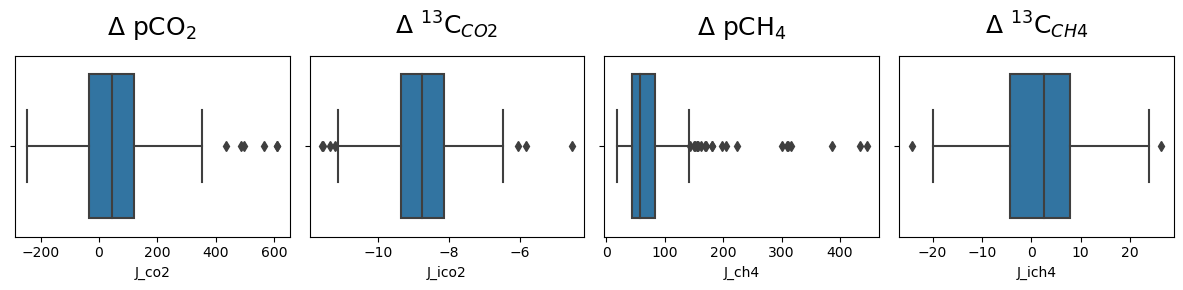

In [7]:
# Set figure and axes
fig, ax = plt.subplots(1,4,figsize =(12,3))

# Box plot
sns.boxplot(x=df_concat['J_co2'], ax=ax[0])
sns.boxplot(x=df_concat['J_ico2'], ax=ax[1])
sns.boxplot(x=df_concat['J_ch4'], ax=ax[2])
sns.boxplot(x=df_concat['J_ich4'], ax=ax[3])
# Titles
ax[0].set_title('$\Delta$ pCO$_2$', fontsize=18, pad=15)
ax[1].set_title('$\Delta$ $^{13}$C$_{CO2}$', fontsize=18, pad=15)
ax[2].set_title('$\Delta$ pCH$_4$', fontsize=18, pad=15)
ax[3].set_title('$\Delta$ $^{13}$C$_{CH4}$', fontsize=18, pad=15)
fig.tight_layout()

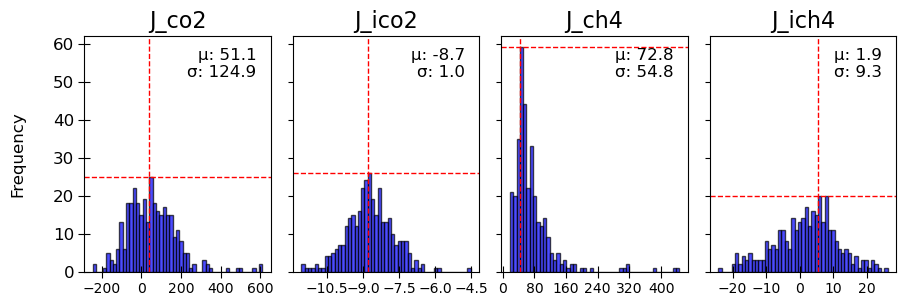

In [8]:
plot_columns_single_row(df_concat, ['J_co2', 'J_ico2', 'J_ch4', 'J_ich4'])

In [9]:
find_min_max_2(df_concat, 'J_co2', 'lat')

Min J_co2 @ -245.1292286560606 on 2016-07-26 09:30:00 @ lat: 60.00073390799243
Max J_co2 @ 609.5005580458333 on 2016-08-01 11:00:00 @ lat: 65.93134207729167


In [10]:
find_min_max_2(df_concat, 'J_ch4', 'lat')

Min J_ch4 @ 17.95198795541667 on 2016-08-10 13:00:00 @ lat: 60.32691413291667
Max J_ch4 @ 445.54231034599997 on 2016-08-01 09:00:00 @ lat: 65.93405747400001


### Separate per Cruise

In [11]:
# Transect I
df1 = df_concat.loc['2016-07-23 00:00:00':'2016-08-04 00:00:00'] 
# Transect II
df2 = df_concat.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00']

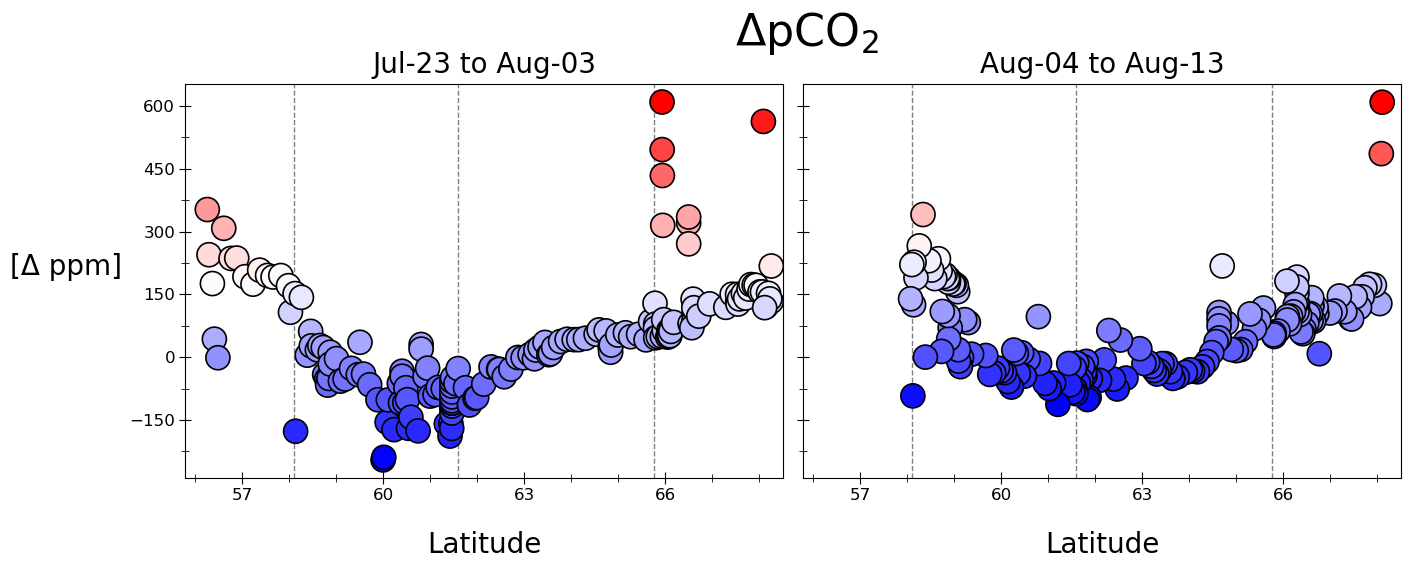

In [12]:
fig, ax = flux_co2('lat', 'J_co2', 'J_co2_std', df1, df2, 'bwr', 'ΔpCO$_2$', r'[Δ ppm]')
#fig.savefig('Chomiak_dco2_24H_kg_hr.png', dpi = 600, bbox_inches='tight')

In [13]:
#fig, ax = flux_co2('lat', 'J_ch4', 'J_ch4_std', df1, df2, 'Purples', 'ΔpCH$_4$')

# Daily Mean

In [14]:
# 30TR Groupby (Water)
df_concat_24H = aggregate_stats(df_concat, freq='24H')
# Sort by Latitude
df_concat_24H = df_concat_24H.sort_values(by='lat', ascending=True)
# Transect I
df1_24H = df_concat_24H.loc['2016-07-23 00:00:00':'2016-08-04 00:00:00'] 
# Transect II
df2_24H = df_concat_24H.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00']

In [15]:
#fig, ax = flux_co2('lat', 'SA_co2', 'SA_co2_std', df1_24H, df2_24H, 'SA_co2_min', 'SA_co2_max', 'bwr', 'SA_co2')

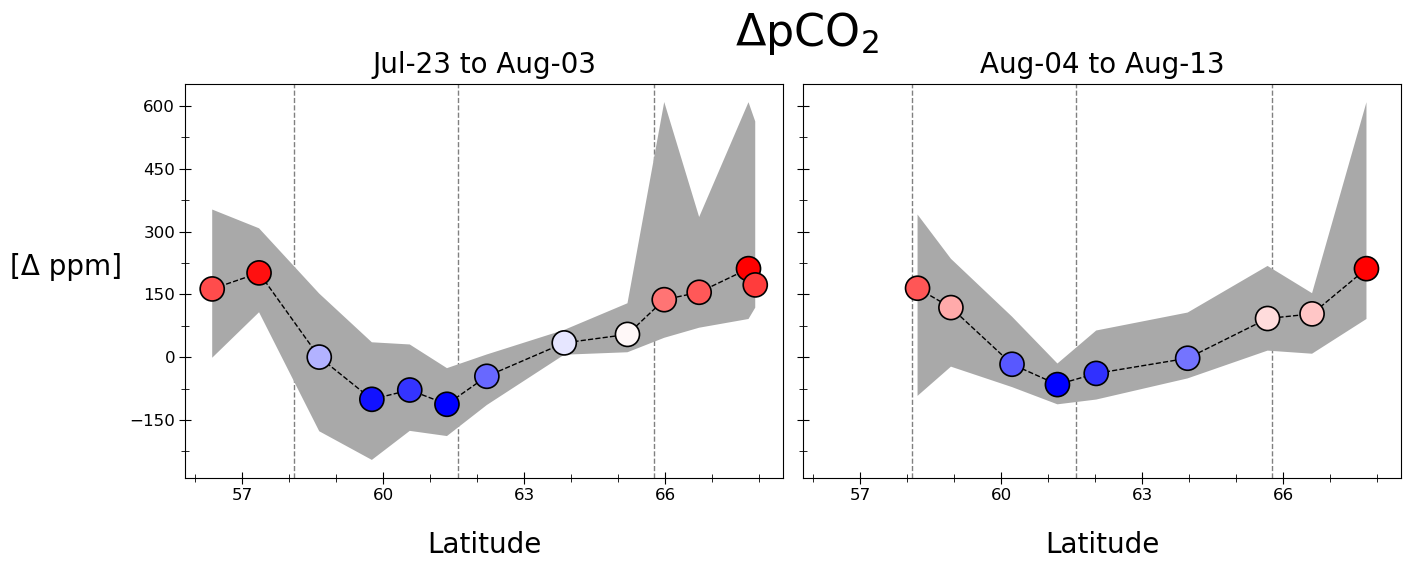

In [16]:
fig, ax = flux_co2_fill('lat', 'J_co2', 'J_co2_std', df1_24H, df2_24H, 'J_co2_min', 'J_co2_max', 'bwr', 'ΔpCO$_2$')
#fig.savefig('Chomiak_dco2_24H_kg_hr.png', dpi = 600, bbox_inches='tight')

<br><br>

# pCO2 Gas Flux

<br><br>

In [17]:
# Salinity [psu]
S=0

# Freshwater Density
FW_density_kgL = 0.9999 #[kg/L]
FW_density_kgm3 = 999.9 #[kg/m3]

<br><br>

### CO2 Gas Solubility Coefficients (Weiss 1974 @ Eq. 12)
- T [K]
<br>

$$ ln(k_0)  =  Α_1 + Α_2\cdot(\frac{100}{T}) + A_3\cdot ln(\frac{T}{100}) + S\cdot((B_1 + B_2\cdot(\frac{T}{100}) + B_3\cdot((\frac{T}{100})^2 ))) $$

<br><br>

In [18]:
# Solubility (k0, [mol/kg•atm])
# CO2 @ k0 [mol/L*atm] ---> [mol/kg*atm]
A1, A2, A3, B1, B2, B3 = [-58.0931, 90.5069, 22.2940, 0.027766, -0.025888, 0.0050578]
coeffs = [A1, A2, A3, B1, B2, B3]
converted_coeffs = [coeff * FW_density_kgL for coeff in coeffs]
A1, A2, A3, B1, B2, B3 = converted_coeffs
df_concat['k_0_co2'] = np.exp(A1 + A2*(100 / (df_concat['t_adcp'] + 273.15)) + A3*np.log((df_concat['t_adcp'] + 273.15) / 100) + S*(B1 + B2*((df_concat['t_adcp'] + 273.15) / 100) + B3*((df_concat['t_adcp'] + 273.15) / 100)**2))

<br><br>

### Schmidt Number (Wanninkhof 2014)
- T [C]
<br>

$$ Sc  =  Α + B\cdot{T} + C\cdot{T}^2 + D\cdot{T}^3 + E\cdot{T}^4 $$

<br><br>

In [19]:
# Schmidt Number @ Sc
FW_co2 = [1923.6, -125.06, 4.3773, -0.085681, 0.00070284]
A, B, C, D, E = FW_co2
df_concat['Sc_co2'] = A + B*(df_concat['t_adcp']) + C*(df_concat['t_adcp']**2) + D*(df_concat['t_adcp']**3) + E*(df_concat['t_adcp']**4)

<br><br>

### Gas Transfer Coefficient (Wanninkhof 2014)

$$ k_g = 0.251 \cdot U_{\text{mean}}^2 \cdot \left( \frac{Sc}{660} \right)^{-0.5} $$

<br><br>

In [20]:
# Air–Water gas exchange coefficient (k_g, [m/s])
df_concat['k_g_co2'] = 0.251 * (df_concat['u']**2) * (df_concat['Sc_co2']/660)**(-0.5)

<br><br>

### Convert from ppm to atm for pCO2
> pCO2_air [ppm] was assumed to be equal to pCO2_air [uatm] <br>

> PYCO2SYS was used to get pCO2_water in uatm units. The inputs: pCO2_water [ppm], Water Temperature, Air Pressure) <br>

> A linear regression was generated to calculated pCO2_water [uatm] from pCO2, water [ppm] <br>

>> CO2_water_uatm = 0.987763 * pCO2_water_ppm - 6.738443

<br><br>

In [21]:
# Convert pco2_water from [ppm] to [atm]
df_concat['pco2_w_uatm'] = 0.9877634535629525*df_concat['co2_w'] - 6.738442916965717

# Convert pco2_air from [ppm] to [atm]
df_concat['p_rad_atm'] = df_concat['p_rad'] / (1013.25) # Change Units of Barometric Pressure (mbar to atm)
df_concat['pco2_a_uatm'] = df_concat['co2_a'] * df_concat['p_rad_atm']

# Flux (atm)
df_concat['Δpco2_atm'] = (df_concat['pco2_w_uatm'] - df_concat['pco2_a_uatm'])*(10**-6)

<br><br>

# Bulk Flux
$$ F  =  k_0 \cdot k_g \cdot (pCO_{2,w} - pCO_{2,a}) \cdot ρ_{w} $$
<br><br>
- k_0 = [mol/kg·atm]
- k_g = [m/s]
- ΔpCO2 = [atm]
- ρ_w = [kg/m3]
<br>

$$ [mol/m2·s] = [mol/kg·atm] * [m/s] * [atm] * [kg/m3] $$

<br><br>

In [22]:
# Flux [mol/m2·s] = k_0 [mol/kg·atm] * k_g [m/s] * [atm] * [kg/m3]
df_concat['Flux_co2_mol_s'] = df_concat['k_0_co2']*df_concat['k_g_co2']*df_concat['Δpco2_atm']*FW_density_kgm3
df_concat['Flux_co2_mol_hr'] = df_concat['Flux_co2_mol_s'] * (60*60)
df_concat['Flux_co2_mol_day'] = df_concat['Flux_co2_mol_s'] * (60*60*24)

In [23]:
# CO2 Flux from [mol/m2·s] to [kg/m2·s]
MW_co2 = (44.01) # [g/mol]
df_concat['Flux_co2_kg_s'] = df_concat['Flux_co2_mol_s'] * MW_co2 * (10**-3)
df_concat['Flux_co2_kg_hr'] = df_concat['Flux_co2_kg_s'] * (60*60)
df_concat['Flux_co2_kg_day'] = df_concat['Flux_co2_kg_s'] * (60*60*24)

In [24]:
# C Flux from [mol/m2·s] to [kg/m2·s]
MW_c = 12.011 # [g/mol]
df_concat['Flux_c_co2_kg_s'] = df_concat['Flux_co2_mol_s'] * MW_c * (10**-3)
df_concat['Flux_c_co2_kg_hr'] = df_concat['Flux_c_co2_kg_s'] * (60*60)
df_concat['Flux_c_co2_kg_day'] = df_concat['Flux_c_co2_kg_s'] * (60*60*24)

### Review Results

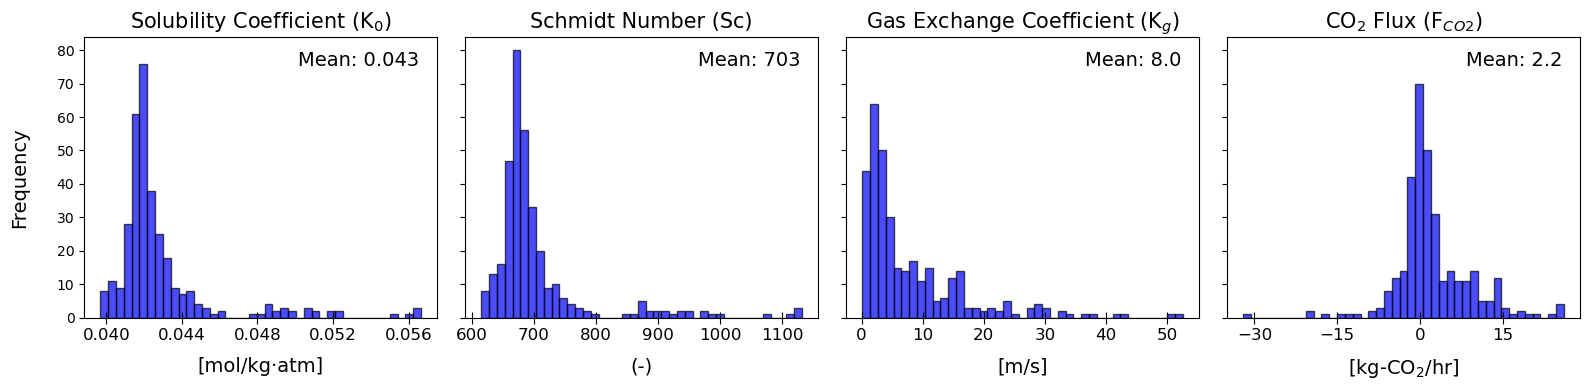

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Data for the first subplot
data_1 = df_concat['k_0_co2']
mean_1 = data_1.mean()
ax[0].hist(data_1, bins=41, edgecolor='black', color='blue', alpha=0.7)
ax[0].set_title('Solubility Coefficient (K$_0$)', fontsize=15)
ax[0].set_xlabel('[mol/kg·atm]', labelpad=10, fontsize=14)
ax[0].set_ylabel('Frequency', labelpad=20, fontsize=14)
ax[0].text(0.95, 0.95, f'Mean: {mean_1:.3f}', fontsize=14, ha='right', va='top', transform=ax[0].transAxes)

# Data for the second subplot
data_2 = df_concat['Sc_co2']
mean_2 = data_2.mean()
ax[1].hist(data_2, bins=41, edgecolor='black', color='blue', alpha=0.7)
ax[1].set_title('Schmidt Number (Sc)', fontsize=15)
ax[1].set_xlabel('(-)', labelpad=10, fontsize=14)
ax[1].text(0.95, 0.95, f'Mean: {mean_2:.0f}', fontsize=14, ha='right', va='top', transform=ax[1].transAxes)

# Data for the third subplot
data_3 = df_concat['k_g_co2']
mean_3 = data_3.mean()
ax[2].hist(data_3, bins=41, edgecolor='black', color='blue', alpha=0.7)
ax[2].set_title('Gas Exchange Coefficient (K$_g$)', fontsize=15)
ax[2].set_xlabel('[m/s]', labelpad=10, fontsize=14)
ax[2].text(0.95, 0.95, f'Mean: {mean_3:.1f}', fontsize=14, ha='right', va='top', transform=ax[2].transAxes)

# Data for the third subplot
data_4 = df_concat['Flux_co2_kg_hr']
mean_4 = data_4.mean()
ax[3].hist(data_4, bins=41, edgecolor='black', color='blue', alpha=0.7)
ax[3].set_title('CO$_2$ Flux (F$_{CO2}$)', fontsize=15)
ax[3].set_xlabel('[kg-CO$_2$/hr]', labelpad=10, fontsize=14)
ax[3].text(0.95, 0.95, f'Mean: {mean_4:.1f}', fontsize=14, ha='right', va='top', transform=ax[3].transAxes)

for ax in ax:
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)

fig.tight_layout()

In [26]:
# Transect I
df1 = df_concat.loc['2016-07-23 00:00:00':'2016-08-04 00:00:00'] 
# Transect II
df2 = df_concat.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00']

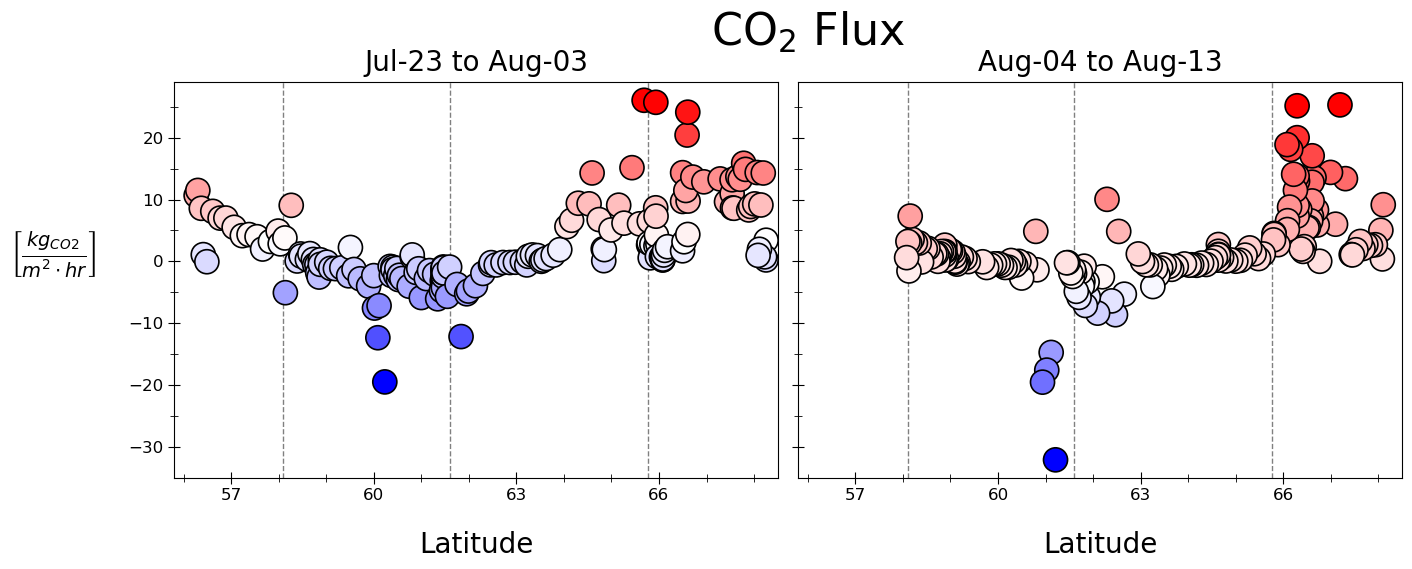

In [27]:
fig, ax = flux_co2('lat', 'Flux_co2_kg_hr', 'Flux_co2_kg_hr', df1, df2, 'bwr', 
                   'CO$_{2}$ Flux', r'$\left[ \frac{kg_{CO2}}{m^{2} \cdot hr} \right]$')

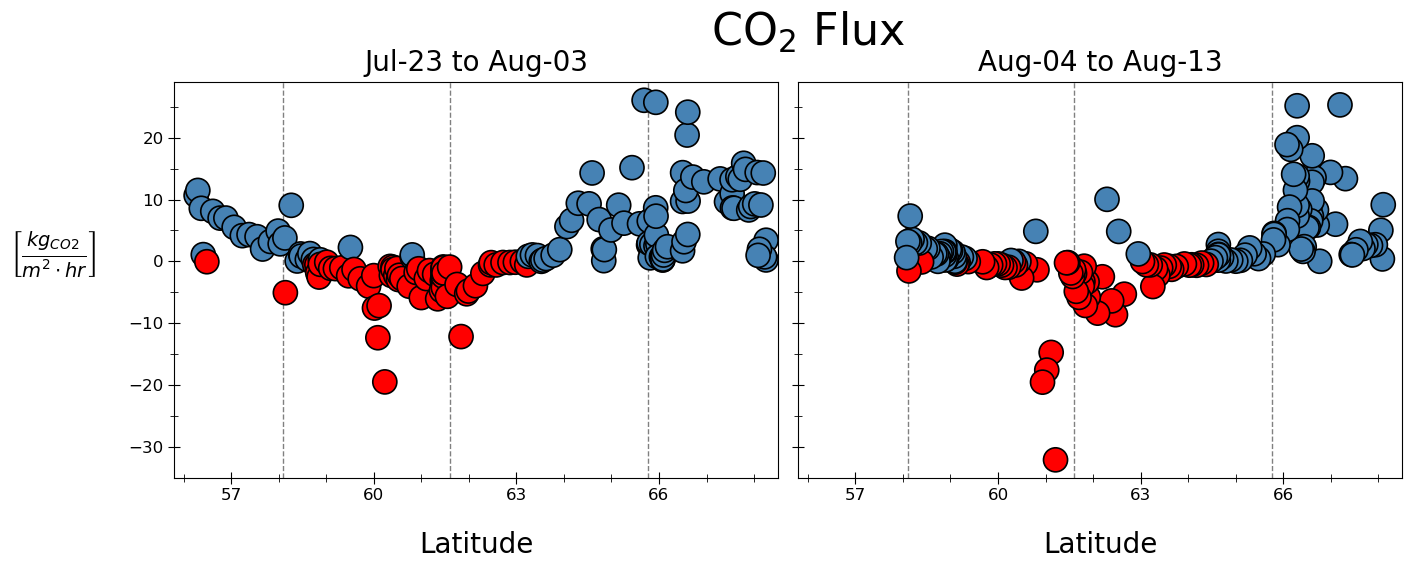

In [28]:
fig, ax = flux_co2_rb('lat', 'Flux_co2_kg_hr', 'Flux_co2_kg_hr', df1, df2, 
                   'CO$_{2}$ Flux', r'$\left[ \frac{kg_{CO2}}{m^{2} \cdot hr} \right]$')

### Notes:

The three vertical lines represent the major tributary inputs. The first (Angara) and third (Nizhnyaya Tunguska) are region of diffusive gas evasion. This means there is more pCO2 in water than air, and pCO2 will diffuse out. The second, middle, tributary (Podkamennaya Tunguska) appears to be a region that acts opposite of the other two tributaries. However, this invasion of pCO2 from air to surface water could also be related to the biogeochemical processes realted to the confluence of the Angara river. The confluence of the Angara tributary is thus an area of interest for geospatial analysis and further studies. 